In [93]:
import pandas as pd
import numpy as np
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [94]:
data = pd.read_excel(r'C:\Users\86180\OneDrive\桌面\STA4020\STA4020-PROJECT\return.xlsx')
print(data)

       Stkcd       Trddt  ChangeRatio
0        568  2022-08-01     0.008101
1        568  2022-08-02    -0.021339
2        568  2022-08-03     0.006295
3        568  2022-08-04     0.023572
4        568  2022-08-05    -0.001417
...      ...         ...          ...
2720  600519  2024-10-25     0.004284
2721  600519  2024-10-28     0.003945
2722  600519  2024-10-29    -0.021329
2723  600519  2024-10-30     0.000248
2724  600519  2024-10-31    -0.002748

[2725 rows x 3 columns]


In [95]:
# I get the returns from 2022.08.01-2024.10.31
returns = data.pivot(index="Trddt", columns="Stkcd", values="ChangeRatio")
print(returns)

has_nan = returns.isna().any().any()
print("Whether the df has nan:", has_nan)

# Take 2022.08.01-2024.07.31 to be in sample, 2024.08.01-2024.10.31 to be out of sample
df_in_sample = returns.loc["2022-08-01":"2024-07-31"]
df_out_sample = returns.loc["2024-08-01":"2024-10-31"]


Stkcd         568       651       858       600276    600519
Trddt                                                       
2022-08-01  0.008101 -0.007517  0.001009 -0.003117 -0.004288
2022-08-02 -0.021339 -0.034838 -0.016351 -0.027857 -0.005459
2022-08-03  0.006295 -0.001255 -0.006091  0.014620  0.002670
2022-08-04  0.023572  0.010685  0.012544  0.057925  0.016451
2022-08-05 -0.001417  0.017887  0.013576  0.035958  0.004149
...              ...       ...       ...       ...       ...
2024-10-25  0.007225 -0.008231  0.011266 -0.013766  0.004284
2024-10-28  0.044064 -0.004895  0.039565  0.012292  0.003945
2024-10-29 -0.018508 -0.003636 -0.020588 -0.008438 -0.021329
2024-10-30 -0.022786 -0.017386 -0.013263 -0.020340  0.000248
2024-10-31 -0.009502 -0.049803 -0.013239 -0.012712 -0.002748

[545 rows x 5 columns]
Whether the df has nan: False


In [96]:
def objective(w, mu, Sigma): # maximizing the Sharpe ratio
    return -np.dot(w, mu) / np.sqrt(np.dot(w.T, np.dot(Sigma, w)))

def optimize_portfolio(mu, Sigma):
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, None) for _ in range(len(mu))]
    initial_weights = np.ones(len(mu)) / len(mu)
    result = minimize(objective, initial_weights, args=(mu, Sigma), bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    return optimal_weights

In [97]:
mu = df_in_sample.mean()
Sigma = df_in_sample.cov()
mve_weights = optimize_portfolio(mu, Sigma)
print("optimal weights for MVE is:")
print(mve_weights)

optimal weights for MVE is:
[0.00000000e+00 7.15270867e-01 0.00000000e+00 2.84729133e-01
 8.60295254e-17]


In [98]:
def portfolio_performance(weights, returns):
    portfolio_returns = np.dot(returns.values, weights)
    avg_return = portfolio_returns.mean()# average return
    std_dev = portfolio_returns.std()# standard deviation of returns
    sharpe_ratio = avg_return / std_dev * np.sqrt(252)# annualized Sharpe ratio 
    return portfolio_returns, avg_return, std_dev, sharpe_ratio

In [99]:
mve_return, mve_avg_return, mve_std_dev, mve_sharpe = portfolio_performance(mve_weights, df_in_sample)

print("MVE Portfolio Performance (in-sample):")
print(f"Average Return: {mve_avg_return:.6f}")
print(f"Standard Deviation: {mve_std_dev:.6f}")
print(f"Annualized Sharpe Ratio: {mve_sharpe:.6f}")

equal_weights = np.ones(len(mu)) / len(mu)
eq_return, eq_avg_return, eq_std_dev, eq_sharpe = portfolio_performance(equal_weights, df_in_sample)

print("Equal-Weighted Portfolio Performance (in-sample):")
print(f"Average Return: {eq_avg_return:.6f}")
print(f"Standard Deviation: {eq_std_dev:.6f}")
print(f"Annualized Sharpe Ratio: {eq_sharpe:.6f}")

MVE Portfolio Performance (in-sample):
Average Return: 0.000697
Standard Deviation: 0.013099
Annualized Sharpe Ratio: 0.844635
Equal-Weighted Portfolio Performance (in-sample):
Average Return: -0.000047
Standard Deviation: 0.013796
Annualized Sharpe Ratio: -0.054005


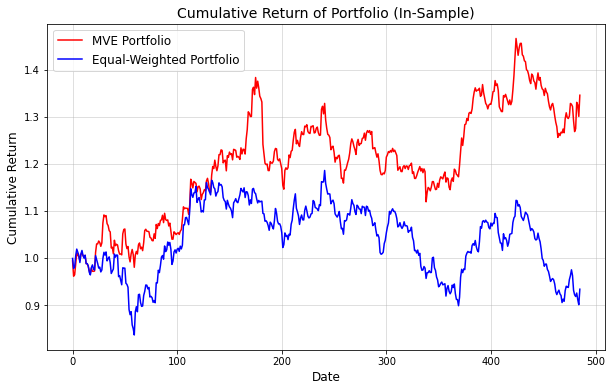

In [102]:
cumulative_mve_return = (1 + mve_return).cumprod()
cumulative_eq_return = (1 + eq_return).cumprod()


plt.figure(figsize=(10, 6))
plt.plot(cumulative_mve_return, label='MVE Portfolio', color='red')
plt.plot(cumulative_eq_return, label='Equal-Weighted Portfolio', color='blue')
plt.title('Cumulative Return of Portfolio (In-Sample)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.show()

In [103]:
P = np.array([
    [-1, 0, 1, 0, 0],
    [0, 0, 1, -1, 0],
    [0, 0, 0, 1, -1]
])
Q = np.array([0.005, 0.0010, 0.0002])
tau = 0.05

mu = df_in_sample.mean()
Sigma = np.cov(df_in_sample.T)
Omega = np.array([[0.01**2, 0, 0], [0, 0.01**2, 0], [0, 0, 0.005**2]])

posterior_cov = np.linalg.inv(
    np.linalg.inv(tau * Sigma) + np.dot(np.dot(P.T, np.linalg.inv(Omega)), P)
)
posterior_mean = np.dot(
    posterior_cov,
    np.dot(np.linalg.inv(tau * Sigma), mu)
    + np.dot(np.dot(P.T, np.linalg.inv(Omega)), Q),
)


bl_weights = optimize_portfolio(posterior_mean, posterior_cov)
print("optimal weights for Black-Litterman Model is:")
print(bl_weights)

optimal weights for Black-Litterman Model is:
[0.00000000e+00 1.00000000e+00 6.49812707e-17 0.00000000e+00
 4.33804522e-17]


In [104]:
mve_return, mve_avg_return, mve_std_dev, mve_sharpe = portfolio_performance(mve_weights, df_out_sample)

print("MVE Portfolio Performance (out-sample):")
print(f"Average Return: {mve_avg_return:.6f}")
print(f"Standard Deviation: {mve_std_dev:.6f}")
print(f"Annualized Sharpe Ratio: {mve_sharpe:.6f}")

equal_weights = np.ones(len(mu)) / len(mu)
eq_return, eq_avg_return, eq_std_dev, eq_sharpe = portfolio_performance(equal_weights, df_out_sample)

print("Equal-Weighted Portfolio Performance (out-sample):")
print(f"Average Return: {eq_avg_return:.6f}")
print(f"Standard Deviation: {eq_std_dev:.6f}")
print(f"Annualized Sharpe Ratio: {eq_sharpe:.6f}")

bl_return, bl_avg_return, bl_std_dev, bl_sharpe = portfolio_performance(bl_weights, df_out_sample)

print("Black-Litterman Model Portfolio Performance (out-sample):")
print(f"Average Return: {bl_avg_return:.6f}")
print(f"Standard Deviation: {bl_std_dev:.6f}")
print(f"Annualized Sharpe Ratio: {bl_sharpe:.6f}")


MVE Portfolio Performance (out-sample):
Average Return: 0.002466
Standard Deviation: 0.022245
Annualized Sharpe Ratio: 1.759865
Equal-Weighted Portfolio Performance (out-sample):
Average Return: 0.002256
Standard Deviation: 0.025918
Annualized Sharpe Ratio: 1.381586
Black-Litterman Model Portfolio Performance (out-sample):
Average Return: 0.002651
Standard Deviation: 0.022995
Annualized Sharpe Ratio: 1.830033


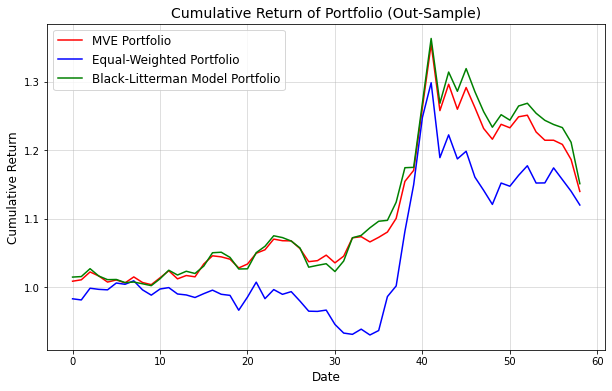

In [106]:
cumulative_mve_return = (1 + mve_return).cumprod()
cumulative_bl_return = (1 + bl_return).cumprod()
cumulative_eq_return = (1 + eq_return).cumprod()


plt.figure(figsize=(10, 6))
plt.plot(cumulative_mve_return, label='MVE Portfolio', color='red')
plt.plot(cumulative_eq_return, label='Equal-Weighted Portfolio', color='blue')
plt.plot(cumulative_bl_return, label='Black-Litterman Model Portfolio', color='green')
plt.title('Cumulative Return of Portfolio (Out-Sample)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.show()

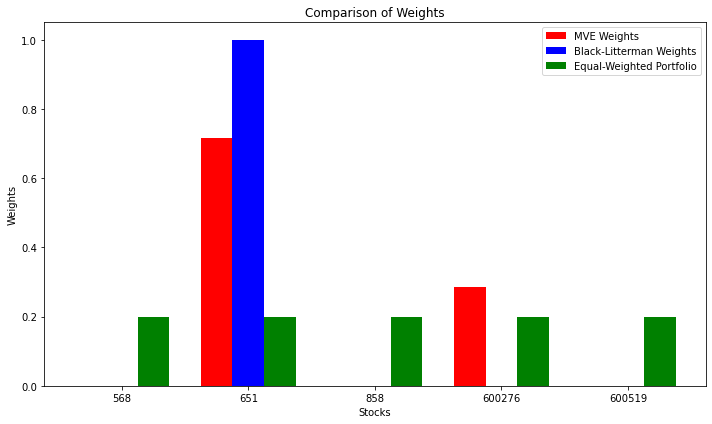

In [107]:
labels = ['568', '651', '858', '600276', '600519'] 
x = np.arange(len(labels)) 
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.25 
ax.bar(x - width, mve_weights, width, label='MVE Weights', color='r')
ax.bar(x , bl_weights, width, label='Black-Litterman Weights', color='b')
ax.bar(x + width, equal_weights, width, label='Equal-Weighted Portfolio', color='g')
equal_weights


ax.set_title('Comparison of Weights')
ax.set_xlabel('Stocks')
ax.set_ylabel('Weights')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()